<a href="https://colab.research.google.com/github/DM2003/DEEP-LEARNING-PROJECTS/blob/main/CIFAR_10_OBJECT_RECOGNITION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
# Configuring the path of kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Dataset API
!kaggle competitions download -c cifar-10

 99% 710M/715M [00:07<00:00, 105MB/s]
100% 715M/715M [00:07<00:00, 107MB/s]


In [4]:
# Extracting the compressed dataset
from zipfile import ZipFile
dataset = '/content/cifar-10.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print("The dataset is extracted")

The dataset is extracted


In [5]:
!ls

cifar-10.zip  kaggle.json  sample_data	sampleSubmission.csv  test.7z  train.7z  trainLabels.csv


In [6]:
# As our training data is in form of 7z file we cannot extract it using Zip file. Hence, we will use py7zr
!pip install py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.2/411.2 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 35.3 MB/s eta 0:00:00


In [7]:
import py7zr

archive = py7zr.SevenZipFile('/content/train.7z', mode = 'r')
archive.extractall()
archive.close()

In [8]:
# Importing the libraries
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [9]:
filenames = os.listdir('/content/train')

In [10]:
type(filenames)

list

In [11]:
len(filenames)

50000

In [12]:
print(filenames[0:5])
print(filenames[-5:])

['43835.png', '17425.png', '1872.png', '19464.png', '20778.png']
['36414.png', '8155.png', '12867.png', '24813.png', '37679.png']


LABELS PROCESSING

In [13]:
labels_df = pd.read_csv('/content/trainLabels.csv') # It basically contains labels of training data and we are storing it in a variable called as labels_df

In [14]:
labels_df.shape

(50000, 2)

In [15]:
labels_df.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [16]:
labels_df.head(10)

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile
5,6,automobile
6,7,bird
7,8,horse
8,9,ship
9,10,cat


In [17]:
labels_df.tail(10)

,id,label
49990,49991,deer
49991,49992,bird
49992,49993,airplane
49993,49994,automobile
49994,49995,airplane
49995,49996,bird
49996,49997,frog
49997,49998,truck
49998,49999,automobile
49999,50000,automobile


In [18]:
labels_df['label'].value_counts()

label
frog          5000
truck         5000
deer          5000
automobile    5000
bird          5000
horse         5000
ship          5000
cat           5000
dog           5000
airplane      5000
Name: count, dtype: int64

In [19]:
labels_df['label']

0              frog
1             truck
2             truck
3              deer
4        automobile
            ...    
49995          bird
49996          frog
49997         truck
49998    automobile
49999    automobile
Name: label, Length: 50000, dtype: object

In [20]:
labels_dictionary = {'airplane':0, 'automobile':1, 'bird':2, 'cat':3, 'deer':4, 'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}
# We are basically iterating over every value of labels_df['label'] with labels_dictionary and successfully encoding them with each iteration
labels = [labels_dictionary[i] for i in labels_df['label']]

In [21]:
# Checking it
print(labels[0:5])
print(labels[-5:])

[6, 9, 9, 4, 1]
[2, 6, 9, 1, 1]


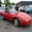

In [22]:
# Displaying sample image
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/train/33119.png') # Converting one picture into a numpy array using cv2.imread
cv2_imshow(img) # Converting that numpy array into it's image form and displaying it

In [23]:
labels_df[labels_df['id'] == 33119]

,id,label
33118,33119,automobile


In [24]:
# We are creating the id column alone in a separate list (id starts from 1 to 50000)
id_list = list(labels_df['id'])

In [25]:
print(id_list[0:5])
print(id_list[-5:])

[1, 2, 3, 4, 5]
[49996, 49997, 49998, 49999, 50000]


IMAGE PROCESSING

In [26]:
# Convert images to numpy array
train_data_folder = '/content/train/'

# Now, we will take all the 50,000 images, convert all those images into 50,000 numpy arrays and store all the arrays inside a list called data
data = []

for id in id_list:
  image = Image.open(train_data_folder + str(id) + '.png')
  image = np.array(image)
  data.append(image)

In [27]:
type(data)

list

In [28]:
len(data)

50000

In [29]:
type(data[0])

numpy.ndarray

In [30]:
data[0].shape

(32, 32, 3)

Thus, the first image is an RGB image with dimensions of 32 by 32

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]], dtype=uint8)
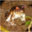

In [31]:
data[0]

Thus scaling will be necessary, which we will do further ahead

In [32]:
# Converting images list and labels list to numpy arrays
X = np.array(data)
Y = np.array(labels)

In [33]:
type(X)
type(Y)

numpy.ndarray

In [34]:
print(X.shape)
print(Y.shape)

(50000, 32, 32, 3)
(50000,)


In [35]:
# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 2)
print(X.shape, X_train.shape, X_test.shape)

(50000, 32, 32, 3) (40000, 32, 32, 3) (10000, 32, 32, 3)


In [36]:
# Now, we are going to scale the data. Since, in our original dataset we have pixel values ranging from 0 to 255, we will change it from 0 to 1
X_train_scaled = X_train/255
X_test_scaled = X_test/255

In [37]:
print(X_train_scaled[0])

[[[0.81960784 0.82352941 0.79607843]
  [0.83529412 0.83921569 0.81960784]
  [0.85490196 0.85882353 0.84313725]
  ...
  [0.49803922 0.29019608 0.15294118]
  [0.47843137 0.26666667 0.1372549 ]
  [0.45490196 0.24705882 0.1254902 ]]

 [[0.82352941 0.82352941 0.79215686]
  [0.83529412 0.83921569 0.81176471]
  [0.85490196 0.8627451  0.83921569]
  ...
  [0.48627451 0.2745098  0.1372549 ]
  [0.4745098  0.2627451  0.12941176]
  [0.48235294 0.27058824 0.14117647]]

 [[0.80784314 0.80392157 0.76470588]
  [0.81960784 0.81960784 0.79215686]
  [0.83529412 0.84313725 0.81960784]
  ...
  [0.48627451 0.2745098  0.14509804]
  [0.51372549 0.30196078 0.16470588]
  [0.51372549 0.30588235 0.16078431]]

 ...

 [[0.49803922 0.42352941 0.38039216]
  [0.54117647 0.47843137 0.43137255]
  [0.55294118 0.49803922 0.4627451 ]
  ...
  [0.61960784 0.58431373 0.5254902 ]
  [0.63137255 0.61176471 0.59215686]
  [0.53333333 0.5372549  0.58039216]]

 [[0.56862745 0.50980392 0.46666667]
  [0.58039216 0.52941176 0.50196078]


In [38]:
import tensorflow as tf
from tensorflow import keras

In [39]:
num_of_classes = 10

# Setting up layers of neural network
model = keras.Sequential([
                         keras.layers.Flatten(input_shape = (32,32,3)),
                         keras.layers.Dense(128, activation = 'relu'),
                         keras.layers.Dense(64, activation = 'relu'),
                         keras.layers.Dense(num_of_classes, activation = 'softmax') # Although, it's not a rule, we generally use sigmoid function in the activation layer when we have binary classification and we use softmax for multi class classification problems
])

In [40]:
# Compiling the neural network
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy']
              )

In [41]:
# Training the neural network
model.fit(X_train_scaled, Y_train, validation_split = 0.1, epochs = 15) # Here model will try to find a relation between X_train_scaled data and corresponding labels stored in Y_train and validation size is 10 percentage of data


Epoch 1/15
1125/1125 [==============================] - 12s 10ms/step - loss: 1.9214 - accuracy: 0.3007 - val_loss: 1.7994 - val_accuracy: 0.3428
Epoch 2/15
1125/1125 [==============================] - 7s 6ms/step - loss: 1.7625 - accuracy: 0.3661 - val_loss: 1.6958 - val_accuracy: 0.3877
Epoch 3/15
1125/1125 [==============================] - 11s 10ms/step - loss: 1.6889 - accuracy: 0.3948 - val_loss: 1.6743 - val_accuracy: 0.3993
Epoch 4/15
1125/1125 [==============================] - 8s 7ms/step - loss: 1.6374 - accuracy: 0.4117 - val_loss: 1.6362 - val_accuracy: 0.4080
Epoch 5/15
1125/1125 [==============================] - 9s 8ms/step - loss: 1.6003 - accuracy: 0.4257 - val_loss: 1.6255 - val_accuracy: 0.4140
Epoch 6/15
1125/1125 [==============================] - 10s 9ms/step - loss: 1.5754 - accuracy: 0.4363 - val_loss: 1.5516 - val_accuracy: 0.4512
Epoch 7/15
1125/1125 [==============================] - 7s 7ms/step - loss: 1.5543 - accuracy: 0.4431 - val_loss: 1.5466 - val_accu

To increase the accuracy, we will train our model using transer learning technique with RESNET50

In [42]:
from tensorflow.keras import Sequential, models, layers
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import optimizers


In [43]:
convolutional_base = ResNet50(weights = 'imagenet', include_top = False, input_shape = (256,256,3))
#imagenet is a data which contains millions of images. Based on the images it will derive some weights
#imagenet contains output for around 1000 classes. But we just need 10 classes for our model. Hence, after loading imagenet we will drop it's output layer. We will add our own custom output layer. Hence, we include include_top = False
#Resnet50 will take images of dimensions 256 by 256 and RGB type. But our dataset is of 32 by 32. Hence, we will reshape it  later.
convolutional_base.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                      

In [44]:
num_of_class = 10
model = models.Sequential()
model.add(layers.UpSampling2D((2,2))) # Here 2, 2 indicates that the height and width of our image will be multiplied 2 times ie: it basically upscales the image (32 x2 = 64, 64)
model.add(layers.UpSampling2D((2,2))) # 64 x 2 = 128, 128
model.add(layers.UpSampling2D((2,2))) # 128 x 2 = 256, 256 and we know ResNet model takes images of size 256 by 256. Hence our images have been successfully upscaled in order to work with ResNet
model.add(convolutional_base)
model.add(layers.Flatten())
model.add(layers.BatchNormalization()) # Makes sure all the values are of same range

model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.5)) # We use this to turn off a few neurons so that model does not overfit
model.add(layers.BatchNormalization())

model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())

model.add(layers.Dense(num_of_class, activation = 'softmax'))

In [45]:
model.compile(
    optimizer = optimizers.RMSprop(lr = 2e-5),# lr or learning rate determines how much weight will change in each neuron with each iteration
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc']
)

In [ ]:
history = model.fit(X_train_scaled, Y_train, validation_split = 0.1, epochs =  10) # This will take around 1 hr to load

Epoch 1/10
   3/1125 [..............................] - ETA: 11:02:50 - loss: 2.8488 - acc: 0.1354

In [ ]:
loss, accuracy = model.evaluate(X_test_scaled, Y_test)
print("Test accuracy = ", accuracy)

In [ ]:
h = history

# Plotting the loss value
plt.plot(h.history['loss'], label = 'train loss')
plt.plot(h.history['val_loss'], label = 'validation loss')
plt.legend()
plt.show()

# Plotting the accuracy value
plt.plot(h.history['acc'], label = 'train accuracy')
plt.plot(h.history['val_acc'], label = 'validation accuracy')
plt.legend()
plt.show()